<a href="https://colab.research.google.com/github/cwilbar04/nba-predictions/blob/main/notebooks/model_data_creation_sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.cloud import bigquery_storage
from google.colab import files
from datetime import datetime
import os

In [5]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [21]:
my_project_id = "nba-predictions-dev"
raw_game_data_table = 'nba.raw_basketballreference_game'
raw_player_data_table = 'nba.raw_basketballreference_playerbox'

In [22]:
credentials = os.environ.get("GOOGLE_APPLICATION_CREDENTIALS")

In [23]:
bqclient = bigquery.Client(credentials=credentials, project=my_project_id,)
bqstorageclient = bigquery_storage.BigQueryReadClient(credentials=credentials)

ValueError: ignored

In [ ]:
game_table = bigquery.TableReference.from_string(
    f'{my_project_id}.{raw_game_data_table}'
)
rows = bqclient.list_rows(
    table,
    selected_fields=[
        bigquery.SchemaField("country_name", "STRING"),
        bigquery.SchemaField("fips_code", "STRING"),
    ],
)
dataframe = rows.to_dataframe(bqstorage_client=bqstorageclient)

In [ ]:
%%bigquery --project nba-predictions-dev game
  SELECT * from `nba.raw_basketballreference_game`

In [ ]:
%%bigquery --project nba-predictions-dev player
  SELECT * from `nba.raw_basketballreference_playerbox`

In [ ]:
game_original = game.copy()
player_original = player.copy()

In [ ]:
game[game['game_date']==game['game_date'].max()]

,game_date,game_start_time,visitor_team_name,away_abbr,visitor_pts,home_team_name,home_abbr,home_pts,box_score_url,attendance,overtimes,game_key,a_g1_score,a_g2_score,a_g3_score,a_g4_score,h_g1_score,h_g2_score,h_g3_score,h_g4_score,a_ff_pace,a_ff_efg_pct,a_ff_tov_pct,a_ff_orb_pct,a_ff_ft_rate,a_ff_off_rtg,h_ff_pace,h_ff_efg_pct,h_ff_tov_pct,h_ff_orb_pct,h_ff_ft_rate,h_ff_off_rtg,load_datetime,a_g5_score,h_g5_score,a_g6_score,h_g6_score
2472,2021-02-25,8:00p,Los Angeles Clippers,LAC,94,Memphis Grizzlies,MEM,122,/boxscores/202102250MEM.html,"1,896",,LAC20210225MEM800p,27,26,22,19,24,37,28,33,96.1,.476,13.3,16.3,.167,97.8,96.1,.603,5.7,17.5,.120,127.0,2021-02-26 12:00:17+00:00,None,None,None,None
2473,2021-02-25,7:00p,Dallas Mavericks,DAL,97,Philadelphia 76ers,PHI,111,/boxscores/202102250PHI.html,0,,DAL20210225PHI700p,22,21,25,29,23,36,27,25,95.6,.494,17.0,24.4,.256,101.5,95.6,.500,6.5,16.7,.233,116.2,2021-02-26 12:00:15+00:00,None,None,None,None
2474,2021-02-25,7:30p,Orlando Magic,ORL,92,Brooklyn Nets,BRK,129,/boxscores/202102250BRK.html,327,,ORL20210225BRK730p,28,19,25,20,24,41,27,37,104.2,.454,16.1,8.3,.149,88.3,104.2,.641,11.7,18.4,.120,123.7,2021-02-26 12:00:16+00:00,None,None,None,None
2475,2021-02-25,7:30p,Sacramento Kings,SAC,121,New York Knicks,NYK,140,/boxscores/202102250NYK.html,"1,981",,SAC20210225NYK730p,29,33,32,27,38,39,24,39,103.5,.565,13.9,19.0,.294,116.9,103.5,.695,14.3,25.7,.218,135.3,2021-02-26 12:00:16+00:00,None,None,None,None
2476,2021-02-25,9:00p,Washington Wizards,WAS,112,Denver Nuggets,DEN,110,/boxscores/202102250DEN.html,0,,WAS20210225DEN900p,26,30,32,24,22,32,34,22,97.1,.523,10.2,23.8,.256,115.4,97.1,.524,15.9,27.3,.247,113.3,2021-02-26 12:00:18+00:00,None,None,None,None
2477,2021-02-25,9:30p,New Orleans Pelicans,NOP,125,Milwaukee Bucks,MIL,129,/boxscores/202102250MIL.html,"1,800",,NOP20210225MIL930p,31,37,35,22,35,34,34,26,102.5,.564,7.7,26.1,.098,121.9,102.5,.609,8.0,18.6,.125,125.9,2021-02-26 12:00:20+00:00,None,None,None,None


In [ ]:
game.head()

,game_date,game_start_time,visitor_team_name,away_abbr,visitor_pts,home_team_name,home_abbr,home_pts,box_score_url,attendance,overtimes,game_key,a_g1_score,a_g2_score,a_g3_score,a_g4_score,h_g1_score,h_g2_score,h_g3_score,h_g4_score,a_ff_pace,a_ff_efg_pct,a_ff_tov_pct,a_ff_orb_pct,a_ff_ft_rate,a_ff_off_rtg,h_ff_pace,h_ff_efg_pct,h_ff_tov_pct,h_ff_orb_pct,h_ff_ft_rate,h_ff_off_rtg,load_datetime,a_g5_score,h_g5_score,a_g6_score,h_g6_score
0,2017-04-01,3:30p,Los Angeles Lakers,LAL,104,Los Angeles Clippers,LAC,115,/boxscores/201704010LAC.html,"19,060",,LAL20170401LAC330p,22,28,22,32,28,27,38,22,95.9,.467,9.6,30.0,.222,108.4,95.9,.630,16.8,13.3,.406,119.9,2021-02-24 19:05:58+00:00,None,None,None,None
1,2017-04-01,5:00p,Atlanta Hawks,ATL,104,Chicago Bulls,CHI,106,/boxscores/201704010CHI.html,"22,019",,ATL20170401CHI500p,21,25,38,20,23,29,27,27,96.0,.506,11.8,24.4,.144,108.3,96.0,.541,11.6,15.0,.165,110.4,2021-02-24 19:05:59+00:00,None,None,None,None
2,2017-04-01,6:00p,Orlando Magic,ORL,111,Brooklyn Nets,BRK,121,/boxscores/201704010BRK.html,"15,976",,ORL20170401BRK600p,33,20,36,22,33,27,29,32,100.0,.549,12.5,23.9,.121,111.0,100.0,.574,9.8,22.5,.138,121.0,2021-02-24 19:06:00+00:00,None,None,None,None
3,2017-04-01,8:00p,Sacramento Kings,SAC,123,Minnesota Timberwolves,MIN,117,/boxscores/201704010MIN.html,"18,960",,SAC20170401MIN800p,18,37,36,32,31,28,26,32,100.9,.635,15.5,18.4,.308,121.9,100.9,.500,8.8,23.3,.345,116.0,2021-02-24 19:06:01+00:00,None,None,None,None
4,2017-04-01,10:00p,Phoenix Suns,PHO,117,Portland Trail Blazers,POR,130,/boxscores/201704010POR.html,"18,915",,PHO20170401POR1000p,21,32,34,30,37,26,34,33,101.6,.542,14.8,30.2,.310,115.2,101.6,.549,10.2,26.8,.315,128.0,2021-02-24 19:06:02+00:00,None,None,None,None


In [ ]:
player.head()

,game_key,game_date,h_or_a,team_abbrev,stat_period,player,player_link,player_key,reason,mp,fg,fga,fg_pct,fg3,fg3a,fg3_pct,ft,fta,ft_pct,orb,drb,trb,ast,stl,blk,tov,pf,pts,plus_minus,player_stat_key,starter_flag,load_datetime
0,MIA20171108PHO900p,2017-11-08,a,MIA,game,Goran Dragi\xc4\x87,/players/d/dragigo01.html,dragigo01,None,38:22,9,19,.474,1,5,.200,10,10,1.000,2,7,9,4,0,0,1,3,29,+6,MIA20171108PHO900p|dragigo01|game,True,2021-02-24 19:13:24+00:00
1,MIA20171108PHO900p,2017-11-08,h,PHO,game,Devin Booker,/players/b/bookede01.html,bookede01,None,37:17,9,23,.391,1,6,.167,11,13,.846,0,3,3,6,1,0,0,3,30,-10,MIA20171108PHO900p|bookede01|game,True,2021-02-24 19:13:24+00:00
2,BOS20160409ATL730p,2016-04-09,h,ATL,game,Paul Millsap,/players/m/millspa01.html,millspa01,None,38:43,13,22,.591,5,7,.714,0,0,None,2,14,16,3,2,5,3,2,31,+20,BOS20160409ATL730p|millspa01|game,True,2021-02-24 17:15:44+00:00
3,CLE20160409CHI830p,2016-04-09,a,CLE,game,LeBron James,/players/j/jamesle01.html,jamesle01,None,38:33,13,17,.765,4,5,.800,3,4,.750,3,4,7,3,0,1,4,1,33,+7,CLE20160409CHI830p|jamesle01|game,True,2021-02-24 17:15:45+00:00
4,MIN20160409POR1030p,2016-04-09,h,POR,game,Damian Lillard,/players/l/lillada01.html,lillada01,None,37:55,11,22,.500,4,10,.400,5,5,1.000,0,3,3,7,1,0,3,3,31,+7,MIN20160409POR1030p|lillada01|game,True,2021-02-24 17:15:46+00:00


In [ ]:
game.describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,game_date,game_start_time,visitor_team_name,away_abbr,visitor_pts,home_team_name,home_abbr,home_pts,box_score_url,attendance,overtimes,game_key,a_g1_score,a_g2_score,a_g3_score,a_g4_score,h_g1_score,h_g2_score,h_g3_score,h_g4_score,a_ff_pace,a_ff_efg_pct,a_ff_tov_pct,a_ff_orb_pct,a_ff_ft_rate,a_ff_off_rtg,h_ff_pace,h_ff_efg_pct,h_ff_tov_pct,h_ff_orb_pct,h_ff_ft_rate,h_ff_off_rtg,load_datetime,a_g5_score,h_g5_score,a_g6_score,h_g6_score
count,7265,7265,7265,7265,7265,7265,7265,7265,7265,7265,7265,7265,7265,7265,7265,7265,7265,7265,7265,7265,7265,7265,7265,7265,7265,7265,7265,7265,7265,7265,7265,7265,7265,419,419,51,51
unique,1123,25,30,30,87,30,30,88,7100,3046,5,7100,43,40,44,44,42,44,44,42,317,363,212,328,400,613,317,366,208,333,410,618,5570,21,22,14,16
top,2017-02-15,8:00p,Boston Celtics,BOS,109,Golden State Warriors,GSW,104,/boxscores/201702110CLE.html,0,,MEM20170203OKC800p,26,26,27,26,29,27,26,25,97.9,.500,10.3,25.0,.198,106.3,97.9,.500,13.0,25.0,.247,114.4,2021-02-24 21:15:54+00:00,12,9,9,9
freq,28,1659,269,269,242,275,275,252,2,351,6846,2,503,493,482,517,493,517,496,504,69,240,98,206,94,40,69,221,104,190,92,41,4,46,49,9,8
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-02-24 16:41:49+00:00,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-02-26 12:00:20+00:00,NaN,NaN,NaN,NaN


In [ ]:
player.describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,game_key,game_date,h_or_a,team_abbrev,stat_period,player,player_link,player_key,reason,mp,fg,fga,fg_pct,fg3,fg3a,fg3_pct,ft,fta,ft_pct,orb,drb,trb,ast,stl,blk,tov,pf,pts,plus_minus,player_stat_key,starter_flag,load_datetime
count,190851,190851,190851,190851,190851,190851,190851,190851,31621,159230,159230,159230,152054,159230,159230,115787,159230,159230,90496,159230,159230,159230,159230,159230,159230,159230,159230,159230,159198,190851,190851,190851
unique,7100,1123,2,30,1,1078,1078,1078,4,2932,25,45,258,15,25,92,25,31,126,16,24,30,25,10,12,13,7,64,100,180491,2,5891
top,ATL20170201MIA730p,2017-02-15,h,TOR,game,P.J. Tucker,/players/t/tuckepj01.html,tuckepj01,Did Not Play,12:00,1,5,.500,0,0,.000,0,0,1.000,0,1,2,0,0,0,0,1,0,0,CHI20170212MIN330p|mirotni01|game,False,2021-02-24 21:14:37+00:00
freq,52,720,95533,7011,190851,522,522,522,27559,463,22798,11751,20654,81350,43443,37907,74191,68734,40388,80424,27658,22229,44847,84938,109861,57382,39130,17169,6934,2,115791,104
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-02-24 16:41:49+00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-02-26 12:00:20+00:00


In [ ]:
game['home_spread'] = game['home_pts'].astype(int) - game['visitor_pts'].astype(int)

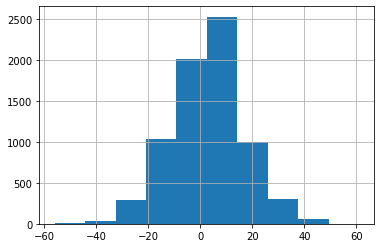

In [ ]:
game['home_spread'].hist()

In [ ]:
game['season'] = ''
for i in range(len(game)-1):
  if ((game['game_date'][i].year != 2020 and game['game_date'][i].month < 7) or (game['game_date'][i].year == 2020 and game['game_date'][i].month < 11)):
    game.loc[i,'season'] = game['game_date'][i].year
  else:
    game.loc[i,'season'] = game['game_date'][i].year + 1


In [ ]:
game.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7265 entries, 0 to 7264
Data columns (total 39 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   game_date          7265 non-null   object             
 1   game_start_time    7265 non-null   object             
 2   visitor_team_name  7265 non-null   object             
 3   away_abbr          7265 non-null   object             
 4   visitor_pts        7265 non-null   object             
 5   home_team_name     7265 non-null   object             
 6   home_abbr          7265 non-null   object             
 7   home_pts           7265 non-null   object             
 8   box_score_url      7265 non-null   object             
 9   attendance         7265 non-null   object             
 10  overtimes          7265 non-null   object             
 11  game_key           7265 non-null   object             
 12  a_g1_score         7265 non-null   object       

In [ ]:
game.head()

,game_date,game_start_time,visitor_team_name,away_abbr,visitor_pts,home_team_name,home_abbr,home_pts,box_score_url,attendance,overtimes,game_key,a_g1_score,a_g2_score,a_g3_score,a_g4_score,h_g1_score,h_g2_score,h_g3_score,h_g4_score,a_ff_pace,a_ff_efg_pct,a_ff_tov_pct,a_ff_orb_pct,a_ff_ft_rate,a_ff_off_rtg,h_ff_pace,h_ff_efg_pct,h_ff_tov_pct,h_ff_orb_pct,h_ff_ft_rate,h_ff_off_rtg,load_datetime,a_g5_score,h_g5_score,a_g6_score,h_g6_score,home_spread,season
0,2017-04-01,3:30p,Los Angeles Lakers,LAL,104,Los Angeles Clippers,LAC,115,/boxscores/201704010LAC.html,"19,060",,LAL20170401LAC330p,22,28,22,32,28,27,38,22,95.9,.467,9.6,30.0,.222,108.4,95.9,.630,16.8,13.3,.406,119.9,2021-02-24 19:05:58+00:00,None,None,None,None,11,2017
1,2017-04-01,5:00p,Atlanta Hawks,ATL,104,Chicago Bulls,CHI,106,/boxscores/201704010CHI.html,"22,019",,ATL20170401CHI500p,21,25,38,20,23,29,27,27,96.0,.506,11.8,24.4,.144,108.3,96.0,.541,11.6,15.0,.165,110.4,2021-02-24 19:05:59+00:00,None,None,None,None,2,2017
2,2017-04-01,6:00p,Orlando Magic,ORL,111,Brooklyn Nets,BRK,121,/boxscores/201704010BRK.html,"15,976",,ORL20170401BRK600p,33,20,36,22,33,27,29,32,100.0,.549,12.5,23.9,.121,111.0,100.0,.574,9.8,22.5,.138,121.0,2021-02-24 19:06:00+00:00,None,None,None,None,10,2017
3,2017-04-01,8:00p,Sacramento Kings,SAC,123,Minnesota Timberwolves,MIN,117,/boxscores/201704010MIN.html,"18,960",,SAC20170401MIN800p,18,37,36,32,31,28,26,32,100.9,.635,15.5,18.4,.308,121.9,100.9,.500,8.8,23.3,.345,116.0,2021-02-24 19:06:01+00:00,None,None,None,None,-6,2017
4,2017-04-01,10:00p,Phoenix Suns,PHO,117,Portland Trail Blazers,POR,130,/boxscores/201704010POR.html,"18,915",,PHO20170401POR1000p,21,32,34,30,37,26,34,33,101.6,.542,14.8,30.2,.310,115.2,101.6,.549,10.2,26.8,.315,128.0,2021-02-24 19:06:02+00:00,None,None,None,None,13,2017


In [ ]:
game.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7265 entries, 0 to 7264
Data columns (total 39 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   game_date          7265 non-null   object             
 1   game_start_time    7265 non-null   object             
 2   visitor_team_name  7265 non-null   object             
 3   away_abbr          7265 non-null   object             
 4   visitor_pts        7265 non-null   object             
 5   home_team_name     7265 non-null   object             
 6   home_abbr          7265 non-null   object             
 7   home_pts           7265 non-null   object             
 8   box_score_url      7265 non-null   object             
 9   attendance         7265 non-null   object             
 10  overtimes          7265 non-null   object             
 11  game_key           7265 non-null   object             
 12  a_g1_score         7265 non-null   object       

In [ ]:
games_by_team_home = pd.DataFrame()
games_by_team_home['season'] = game['season']
games_by_team_home['game_key'] = game['game_key'] + 'h'
games_by_team_home['game_date'] = pd.to_datetime(game['game_date'])
games_by_team_home['team'] = game['home_team_name']
games_by_team_home['opponent'] = game['visitor_team_name']
games_by_team_home['home?'] = 1
games_by_team_home['spread'] = game['home_spread']
games_by_team_home['pace'] = game['h_ff_pace']
games_by_team_home['efg_pct'] = game['h_ff_efg_pct']
games_by_team_home['tov_pct'] = game['h_ff_tov_pct']
games_by_team_home['ft_rate'] = game['h_ff_ft_rate']
games_by_team_home['off_rtg'] = game['h_ff_off_rtg']
games_by_team_home['opponent_efg_pct'] = game['a_ff_efg_pct']
games_by_team_home['opponent_tov_pct'] = game['a_ff_tov_pct']
games_by_team_home['opponent_ft_rate'] = game['a_ff_ft_rate']
games_by_team_home['opponent_off_rtg'] = game['a_ff_off_rtg']


games_by_team_home['result'] = ''
for i in range(len(game)-1):
  games_by_team_home.loc[i,'result'] = 1 if game['home_spread'][i].astype(int) > 0 else 0

In [ ]:
games_by_team_home.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7265 entries, 0 to 7264
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   season            7265 non-null   object        
 1   game_key          7265 non-null   object        
 2   game_date         7265 non-null   datetime64[ns]
 3   team              7265 non-null   object        
 4   opponent          7265 non-null   object        
 5   home?             7265 non-null   int64         
 6   spread            7265 non-null   int64         
 7   pace              7265 non-null   object        
 8   efg_pct           7265 non-null   object        
 9   tov_pct           7265 non-null   object        
 10  ft_rate           7265 non-null   object        
 11  off_rtg           7265 non-null   object        
 12  opponent_pace     7265 non-null   object        
 13  opponent_efg_pct  7265 non-null   object        
 14  opponent_tov_pct  7265 n

In [ ]:
games_by_team_visitor = pd.DataFrame()
games_by_team_visitor ['season'] = game['season']
games_by_team_visitor ['game_key'] = game['game_key'] + 'a'
games_by_team_visitor ['game_date'] = pd.to_datetime(game['game_date'])
games_by_team_visitor ['team'] = game['visitor_team_name']
games_by_team_visitor ['opponent'] = game['home_team_name']
games_by_team_visitor ['home?'] = 0
games_by_team_visitor ['spread'] = game['home_spread']*-1
games_by_team_visitor ['pace'] = game['a_ff_pace']
games_by_team_visitor ['efg_pct'] = game['a_ff_efg_pct']
games_by_team_visitor ['tov_pct'] = game['a_ff_tov_pct']
games_by_team_visitor ['ft_rate'] = game['a_ff_ft_rate']
games_by_team_visitor ['off_rtg'] = game['a_ff_off_rtg']
games_by_team_visitor['opponent_efg_pct'] = game['h_ff_efg_pct']
games_by_team_visitor['opponent_tov_pct'] = game['h_ff_tov_pct']
games_by_team_visitor['opponent_ft_rate'] = game['h_ff_ft_rate']
games_by_team_visitor['opponent_off_rtg'] = game['h_ff_off_rtg']

games_by_team_visitor['result'] = ''
for i in range(len(game)-1):
  games_by_team_visitor.loc[i,'result'] = 1 if game['home_spread'][i].astype(int) < 0 else 0

In [ ]:
games_by_team_visitor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7265 entries, 0 to 7264
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   season            7265 non-null   object        
 1   game_key          7265 non-null   object        
 2   game_date         7265 non-null   datetime64[ns]
 3   team              7265 non-null   object        
 4   opponent          7265 non-null   object        
 5   home?             7265 non-null   int64         
 6   spread            7265 non-null   int64         
 7   pace              7265 non-null   object        
 8   efg_pct           7265 non-null   object        
 9   tov_pct           7265 non-null   object        
 10  ft_rate           7265 non-null   object        
 11  off_rtg           7265 non-null   object        
 12  opponent_pace     7265 non-null   object        
 13  opponent_efg_pct  7265 non-null   object        
 14  opponent_tov_pct  7265 n

In [ ]:
frames = [games_by_team_home,games_by_team_visitor]
games_by_team = pd.concat(frames)

In [ ]:
games_by_team.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14530 entries, 0 to 7264
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   season            14530 non-null  object        
 1   game_key          14530 non-null  object        
 2   game_date         14530 non-null  datetime64[ns]
 3   team              14530 non-null  object        
 4   opponent          14530 non-null  object        
 5   home?             14530 non-null  int64         
 6   spread            14530 non-null  int64         
 7   pace              14530 non-null  object        
 8   efg_pct           14530 non-null  object        
 9   tov_pct           14530 non-null  object        
 10  ft_rate           14530 non-null  object        
 11  off_rtg           14530 non-null  object        
 12  opponent_pace     14530 non-null  object        
 13  opponent_efg_pct  14530 non-null  object        
 14  opponent_tov_pct  14530

In [ ]:
games_by_team.head()

,season,game_key,game_date,team,opponent,home?,spread,pace,efg_pct,tov_pct,ft_rate,off_rtg,opponent_pace,opponent_efg_pct,opponent_tov_pct,opponent_ft_rate,opponent_off_rtg,result
0,2017,LAL20170401LAC330ph,2017-04-01,Los Angeles Clippers,Los Angeles Lakers,1,11,95.9,.630,16.8,.406,119.9,95.9,.467,9.6,.222,108.4,1
1,2017,ATL20170401CHI500ph,2017-04-01,Chicago Bulls,Atlanta Hawks,1,2,96.0,.541,11.6,.165,110.4,96.0,.506,11.8,.144,108.3,1
2,2017,ORL20170401BRK600ph,2017-04-01,Brooklyn Nets,Orlando Magic,1,10,100.0,.574,9.8,.138,121.0,100.0,.549,12.5,.121,111.0,1
3,2017,SAC20170401MIN800ph,2017-04-01,Minnesota Timberwolves,Sacramento Kings,1,-6,100.9,.500,8.8,.345,116.0,100.9,.635,15.5,.308,121.9,0
4,2017,PHO20170401POR1000ph,2017-04-01,Portland Trail Blazers,Phoenix Suns,1,13,101.6,.549,10.2,.315,128.0,101.6,.542,14.8,.310,115.2,1


In [ ]:
player.head()

,game_key,game_date,h_or_a,team_abbrev,stat_period,player,player_link,player_key,reason,mp,fg,fga,fg_pct,fg3,fg3a,fg3_pct,ft,fta,ft_pct,orb,drb,trb,ast,stl,blk,tov,pf,pts,plus_minus,player_stat_key,starter_flag,load_datetime
0,MIA20171108PHO900p,2017-11-08,a,MIA,game,Goran Dragi\xc4\x87,/players/d/dragigo01.html,dragigo01,None,38:22,9,19,.474,1,5,.200,10,10,1.000,2,7,9,4,0,0,1,3,29,+6,MIA20171108PHO900p|dragigo01|game,True,2021-02-24 19:13:24+00:00
1,MIA20171108PHO900p,2017-11-08,h,PHO,game,Devin Booker,/players/b/bookede01.html,bookede01,None,37:17,9,23,.391,1,6,.167,11,13,.846,0,3,3,6,1,0,0,3,30,-10,MIA20171108PHO900p|bookede01|game,True,2021-02-24 19:13:24+00:00
2,BOS20160409ATL730p,2016-04-09,h,ATL,game,Paul Millsap,/players/m/millspa01.html,millspa01,None,38:43,13,22,.591,5,7,.714,0,0,None,2,14,16,3,2,5,3,2,31,+20,BOS20160409ATL730p|millspa01|game,True,2021-02-24 17:15:44+00:00
3,CLE20160409CHI830p,2016-04-09,a,CLE,game,LeBron James,/players/j/jamesle01.html,jamesle01,None,38:33,13,17,.765,4,5,.800,3,4,.750,3,4,7,3,0,1,4,1,33,+7,CLE20160409CHI830p|jamesle01|game,True,2021-02-24 17:15:45+00:00
4,MIN20160409POR1030p,2016-04-09,h,POR,game,Damian Lillard,/players/l/lillada01.html,lillada01,None,37:55,11,22,.500,4,10,.400,5,5,1.000,0,3,3,7,1,0,3,3,31,+7,MIN20160409POR1030p|lillada01|game,True,2021-02-24 17:15:46+00:00


In [ ]:
player['game_key'] = player['game_key'] + player['h_or_a']

In [ ]:
player = player.dropna(subset=['mp', 'plus_minus']).reset_index(drop=True)

In [ ]:
player['plus_minus'] = player['plus_minus'].astype(int)

In [ ]:
def convert_to_seconds(x):
  sp = int(x.split(':')[0]) * 60 + int(x.split(':')[1])
  return sp

In [ ]:
player['seconds_played'] = player['mp'].apply(convert_to_seconds)

In [ ]:
player['seconds_played'] = player['seconds_played'].astype(int)

In [ ]:
game_player_stats = pd.DataFrame()
game_player_stats['game_key'] = player['game_key'].unique()

In [ ]:
game_player_stats.head()

,game_key
0,MIA20171108PHO900pa
1,MIA20171108PHO900ph
2,BOS20160409ATL730ph
3,CLE20160409CHI830pa
4,MIN20160409POR1030ph


In [ ]:
a = player.groupby(['game_key'])['seconds_played'].sum()

In [ ]:
b = player[player['starter_flag']==True].groupby(['game_key'])['seconds_played'].sum()

In [ ]:
seconds = pd.merge(a, b, left_index=True, right_index=True, how='inner')

In [ ]:
seconds['starter_minutes_played_proportion'] = seconds['seconds_played_y']/seconds['seconds_played_x']

In [ ]:
seconds.head()

,seconds_played_x,seconds_played_y,starter_minutes_played_proportion
game_key,,,
ATL20150307PHI730pa,14400,8553,0.593958
ATL20150307PHI730ph,14400,8817,0.612292
ATL20150311DEN900pa,14400,7150,0.496528
ATL20150311DEN900ph,14400,7053,0.489792
ATL20150313PHO1000pa,14400,10095,0.701042


In [ ]:
game_player_stats.set_index('game_key',inplace=True)

In [ ]:
game_player_stats = pd.merge(game_player_stats,seconds['starter_minutes_played_proportion'],left_index=True,right_index=True,how='inner')

In [ ]:
game_player_stats.head()

,starter_minutes_played_proportion
game_key,
MIA20171108PHO900pa,0.659167
MIA20171108PHO900ph,0.604264
BOS20160409ATL730ph,0.641597
CLE20160409CHI830pa,0.752500
MIN20160409POR1030ph,0.698035


In [ ]:
bench_pl_min = player[player['starter_flag']==False].groupby(['game_key'])['plus_minus'].sum()

In [ ]:
game_player_stats = pd.merge(game_player_stats,bench_pl_min, left_index=True, right_index=True, how='inner')

In [ ]:
game_player_stats = game_player_stats.rename(columns={'plus_minus':'bench_plus_minus'})

In [ ]:
game_player_stats.head()

,starter_minutes_played_proportion,bench_plus_minus
game_key,,
MIA20171108PHO900pa,0.659167,11
MIA20171108PHO900ph,0.604264,-46
BOS20160409ATL730ph,0.641597,-18
CLE20160409CHI830pa,0.752500,-48
MIN20160409POR1030ph,0.698035,-37


In [ ]:
games_by_team.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14530 entries, 0 to 7264
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   season            14530 non-null  object        
 1   game_key          14530 non-null  object        
 2   game_date         14530 non-null  datetime64[ns]
 3   team              14530 non-null  object        
 4   opponent          14530 non-null  object        
 5   home?             14530 non-null  int64         
 6   spread            14530 non-null  int64         
 7   pace              14530 non-null  object        
 8   efg_pct           14530 non-null  object        
 9   tov_pct           14530 non-null  object        
 10  ft_rate           14530 non-null  object        
 11  off_rtg           14530 non-null  object        
 12  opponent_pace     14530 non-null  object        
 13  opponent_efg_pct  14530 non-null  object        
 14  opponent_tov_pct  14530

In [ ]:
games_by_team.set_index('game_key', inplace=True)

In [ ]:
games_by_team = pd.merge(games_by_team,game_player_stats, left_index=True, right_index=True,how='inner')

In [ ]:
games_by_team.head()

,season,game_date,team,opponent,home?,spread,pace,efg_pct,tov_pct,ft_rate,off_rtg,opponent_pace,opponent_efg_pct,opponent_tov_pct,opponent_ft_rate,opponent_off_rtg,result,starter_minutes_played_proportion,bench_plus_minus
game_key,,,,,,,,,,,,,,,,,,,
ATL20150307PHI730pa,2015,2015-03-07,Atlanta Hawks,Philadelphia 76ers,0,-8,97.1,.461,18.4,.169,86.5,97.1,.437,13.5,.095,94.8,0,0.593958,-4
ATL20150307PHI730ph,2015,2015-03-07,Philadelphia 76ers,Atlanta Hawks,1,8,97.1,.437,13.5,.095,94.8,97.1,.461,18.4,.169,86.5,1,0.612292,2
ATL20150311DEN900pa,2015,2015-03-11,Atlanta Hawks,Denver Nuggets,0,-13,97.9,.475,15.5,.309,104.2,97.9,.577,17.0,.214,117.4,0,0.496528,6
ATL20150311DEN900ph,2015,2015-03-11,Denver Nuggets,Atlanta Hawks,1,13,97.9,.577,17.0,.214,117.4,97.9,.475,15.5,.309,104.2,1,0.489792,-21
ATL20150313PHO1000pa,2015,2015-03-13,Atlanta Hawks,Phoenix Suns,0,9,91.1,.518,11.1,.120,105.3,91.1,.474,17.1,.167,95.5,1,0.701042,34


In [ ]:
game_player_stats

,starter_minutes_played_proportion,bench_plus_minus
game_key,,
MIA20171108PHO900pa,0.659167,11
MIA20171108PHO900ph,0.604264,-46
BOS20160409ATL730ph,0.641597,-18
CLE20160409CHI830pa,0.752500,-48
MIN20160409POR1030ph,0.698035,-37
...,...,...
CHO20181229WAS700ph,0.769792,13
CHO20150322MIN700ph,0.737708,-17
ORL20190330IND700pa,0.658401,57


In [ ]:
game_player_stats_opponent = game_player_stats.copy()

In [ ]:
game_player_stats_opponent.reset_index(drop=False, inplace=True)

In [ ]:
def switch_key(key):
  new_key = key[:-1] + ('h' if key[-1] == 'a' else 'a')
  return new_key

In [ ]:
game_player_stats_opponent['game_key'] = game_player_stats_opponent['game_key'].apply(switch_key)

In [ ]:
game_player_stats_opponent = game_player_stats_opponent.rename(columns={'starter_minutes_played_proportion':'opponnent_starter_minutes_played_proportion','bench_plus_minus':'opponent_bench_plus_minus'})

In [ ]:
game_player_stats_opponent.set_index('game_key', inplace=True)

In [ ]:
games_by_team = pd.merge(games_by_team,game_player_stats_opponent,left_index=True,right_index=True,how='inner')

In [ ]:
games_by_team.head()

,season,game_date,team,opponent,home?,spread,pace,efg_pct,tov_pct,ft_rate,off_rtg,opponent_pace,opponent_efg_pct,opponent_tov_pct,opponent_ft_rate,opponent_off_rtg,result,starter_minutes_played_proportion,bench_plus_minus,opponnent_starter_minutes_played_proportion,opponent_bench_plus_minus
game_key,,,,,,,,,,,,,,,,,,,,,
ATL20150307PHI730pa,2015,2015-03-07,Atlanta Hawks,Philadelphia 76ers,0,-8,97.1,.461,18.4,.169,86.5,97.1,.437,13.5,.095,94.8,0,0.593958,-4,0.612292,2
ATL20150307PHI730ph,2015,2015-03-07,Philadelphia 76ers,Atlanta Hawks,1,8,97.1,.437,13.5,.095,94.8,97.1,.461,18.4,.169,86.5,1,0.612292,2,0.593958,-4
ATL20150311DEN900pa,2015,2015-03-11,Atlanta Hawks,Denver Nuggets,0,-13,97.9,.475,15.5,.309,104.2,97.9,.577,17.0,.214,117.4,0,0.496528,6,0.489792,-21
ATL20150311DEN900ph,2015,2015-03-11,Denver Nuggets,Atlanta Hawks,1,13,97.9,.577,17.0,.214,117.4,97.9,.475,15.5,.309,104.2,1,0.489792,-21,0.496528,6
ATL20150313PHO1000pa,2015,2015-03-13,Atlanta Hawks,Phoenix Suns,0,9,91.1,.518,11.1,.120,105.3,91.1,.474,17.1,.167,95.5,1,0.701042,34,0.720694,-31


In [ ]:
games_by_team.loc[(games_by_team['team']=='Atlanta Hawks') & (games_by_team['season']==2019)]

,season,game_date,team,opponent,home?,spread,pace,efg_pct,tov_pct,ft_rate,off_rtg,opponent_pace,opponent_efg_pct,opponent_tov_pct,opponent_ft_rate,opponent_off_rtg,result,starter_minutes_played_proportion,bench_plus_minus,opponnent_starter_minutes_played_proportion,opponent_bench_plus_minus
game_key,,,,,,,,,,,,,,,,,,,,,
ATL20181017NYK730pa,2019,2018-10-17,Atlanta Hawks,New York Knicks,0,-19,113.5,.511,19.7,.167,94.3,113.5,.515,11.8,.242,111.0,0,0.587986,-45,0.523958,49
ATL20181019MEM800pa,2019,2018-10-19,Atlanta Hawks,Memphis Grizzlies,0,-14,106.0,.578,16.1,.253,110.4,106.0,.623,13.8,.370,123.6,0,0.519444,-26,0.495208,-49
ATL20181021CLE600pa,2019,2018-10-21,Atlanta Hawks,Cleveland Cavaliers,0,22,106.0,.602,10.1,.153,125.5,106.0,.515,14.6,.091,104.7,1,0.585069,57,0.642569,-79
ATL20181029PHI700pa,2019,2018-10-29,Atlanta Hawks,Philadelphia 76ers,0,-21,105.5,.415,11.2,.149,87.2,105.5,.485,15.1,.172,107.1,0,0.508819,-39,0.579722,39
ATL20181030CLE700pa,2019,2018-10-30,Atlanta Hawks,Cleveland Cavaliers,0,-22,105.7,.628,19.7,.134,107.8,105.7,.572,10.7,.367,128.6,0,0.566806,-14,0.595486,-37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TOR20181121ATL730ph,2019,2018-11-21,Atlanta Hawks,Toronto Raptors,1,-16,99.7,.505,8.2,.151,108.3,99.7,.594,14.5,.189,124.3,0,0.498333,4,0.660764,-18
TOR20190207ATL730ph,2019,2019-02-07,Atlanta Hawks,Toronto Raptors,1,-18,96.9,.550,15.7,.163,104.2,96.9,.534,7.3,.299,122.7,0,0.625139,-1,0.697083,34
UTA20190321ATL730ph,2019,2019-03-21,Atlanta Hawks,Utah Jazz,1,3,102.8,.580,14.1,.184,113.8,102.8,.511,12.5,.191,110.9,1,0.631597,13,0.645208,-18


In [ ]:
def generate_streak_info(data,column):
    """
    Parameters
    ----------
    data:
      Dataframe with a specific column to generate streak data

    column:
      Stirng with specific column name to generate streak info

    Returns
    -------

    data_with_streak_counter:
        The original dataframe with a new column
        `streak_counter_[column]` containing integers with 
        counts for each streak.
    """
    
    data['start_of_streak'] = data[column].ne(data[column].shift())
    data['streak_id'] = data.start_of_streak.cumsum()
    data[f'streak_counter_{column}'] = data.groupby('streak_id').cumcount() + 1
    data_with_streak_counter = data.drop(columns = ['start_of_streak','streak_id'] )
    return data_with_streak_counter

In [ ]:
testing = games_by_team.loc[(games_by_team['team']=='Atlanta Hawks') & (games_by_team['season']==2019)].sort_values(by=['game_date'])
testing2 = games_by_team.loc[(games_by_team['team']=='Washington Wizards') & (games_by_team['season']==2019)].sort_values(by=['game_date'])

In [ ]:
testing = generate_streak_info(testing,'result')
testing2 = generate_streak_info(testing2,'result')

In [ ]:
# Make negative streak if losing streak, positive if winning streak
testing['streak_counter_result'] = [x * -1 if y == 0 else x for x,y in zip(testing['streak_counter_result'],testing['result'])]
testing['incoming_result_streak'] = testing['streak_counter_result'].shift(fill_value=0)
testing2['streak_counter_result'] = [x * -1 if y == 0 else x for x,y in zip(testing2['streak_counter_result'],testing2['result'])]
testing2['incoming_result_streak'] = testing2['streak_counter_result'].shift(fill_value=0)


In [ ]:
test = pd.concat([testing, testing2])

In [ ]:
test.head()

,season,game_date,team,opponent,home?,spread,pace,efg_pct,tov_pct,ft_rate,off_rtg,opponent_pace,opponent_efg_pct,opponent_tov_pct,opponent_ft_rate,opponent_off_rtg,result,starter_minutes_played_proportion,bench_plus_minus,opponnent_starter_minutes_played_proportion,opponent_bench_plus_minus,streak_counter_result,incoming_result_streak
game_key,,,,,,,,,,,,,,,,,,,,,,,
ATL20181017NYK730pa,2019,2018-10-17,Atlanta Hawks,New York Knicks,0,-19,113.5,.511,19.7,.167,94.3,113.5,.515,11.8,.242,111.0,0,0.587986,-45,0.523958,49,-1,0
ATL20181019MEM800pa,2019,2018-10-19,Atlanta Hawks,Memphis Grizzlies,0,-14,106.0,.578,16.1,.253,110.4,106.0,.623,13.8,.370,123.6,0,0.519444,-26,0.495208,-49,-2,-1
ATL20181021CLE600pa,2019,2018-10-21,Atlanta Hawks,Cleveland Cavaliers,0,22,106.0,.602,10.1,.153,125.5,106.0,.515,14.6,.091,104.7,1,0.585069,57,0.642569,-79,1,-2
DAL20181024ATL700ph,2019,2018-10-24,Atlanta Hawks,Dallas Mavericks,1,7,108.1,.489,12.5,.242,102.7,108.1,.484,14.2,.176,96.2,1,0.611806,2,0.677431,39,2,1
CHI20181027ATL730ph,2019,2018-10-27,Atlanta Hawks,Chicago Bulls,1,-12,101.7,.393,18.9,.226,83.6,101.7,.506,18.2,.157,95.3,0,0.566250,25,0.540833,49,-1,2


In [ ]:
test.loc[(test['team']=='Washington Wizards') & (test['season']==2019)]

,season,game_date,team,opponent,home?,spread,pace,efg_pct,tov_pct,ft_rate,off_rtg,opponent_pace,opponent_efg_pct,opponent_tov_pct,opponent_ft_rate,opponent_off_rtg,result,starter_minutes_played_proportion,bench_plus_minus,opponnent_starter_minutes_played_proportion,opponent_bench_plus_minus,streak_counter_result,incoming_result_streak
game_key,,,,,,,,,,,,,,,,,,,,,,,
MIA20181018WAS800ph,2019,2018-10-18,Washington Wizards,Miami Heat,1,-1,101.9,.512,12.5,.358,109.9,101.9,.454,12.5,.258,110.8,0,0.554514,-8,0.652639,13,-1,0
TOR20181020WAS700ph,2019,2018-10-20,Washington Wizards,Toronto Raptors,1,-4,102.0,.489,9.6,.292,110.7,102.0,.500,14.1,.330,114.7,0,0.596111,-44,0.570972,-7,-2,-1
WAS20181022POR1000pa,2019,2018-10-22,Washington Wizards,Portland Trail Blazers,0,1,107.4,.486,7.6,.164,105.4,107.4,.449,13.5,.250,104.6,1,0.592327,0,0.598113,-2,1,-2
WAS20181024GSW1030pa,2019,2018-10-24,Washington Wizards,Golden State Warriors,0,-22,106.7,.516,10.2,.280,114.3,106.7,.658,12.7,.250,134.9,0,0.433194,-49,0.551528,32,-1,1
WAS20181026SAC1000pa,2019,2018-10-26,Washington Wizards,Sacramento Kings,0,-4,108.9,.547,17.9,.209,102.8,108.9,.537,14.6,.147,106.5,0,0.636111,11,0.635000,-48,-2,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WAS20190331DEN800pa,2019,2019-03-31,Washington Wizards,Denver Nuggets,0,5,99.6,.435,9.0,.163,95.4,99.6,.414,9.8,.140,90.4,1,0.738333,12,0.609514,-31,1,-1
CHI20190403WAS700ph,2019,2019-04-03,Washington Wizards,Chicago Bulls,1,-1,107.8,.490,10.0,.196,105.7,107.8,.561,17.0,.156,106.7,0,0.609514,0,0.538403,11,-1,1
SAS20190405WAS700ph,2019,2019-04-05,Washington Wizards,San Antonio Spurs,1,-17,94.3,.528,8.4,.216,118.8,94.3,.615,8.3,.187,136.8,0,0.655694,-48,0.585556,16,-2,-1


In [ ]:
testing = games_by_team.loc[(games_by_team['team']=='Atlanta Hawks') & (games_by_team['season']==2019)].sort_values(by=['game_date'])

In [ ]:
testing['pace'].unique()

array(['113.5', '106.0', '108.1', '101.7', '105.5', '105.7', '112.9',
       '100.5', '108.0', '101.5', '102.9', '103.9', '96.8', '106.2',
       '107.4', '107.1', '99.7', '106.6', '101.6', '106.7', '104.0',
       '107.5', '110.6', '101.3', '106.5', '101.2', '102.8', '100.6',
       '101.8', '102.3', '99.8', '96.9', '99.6', '112.3', '97.3', '103.8',
       '104.8', '98.1', '110.2', '104.9', '101.1', '99.3', '97.8', '98.0',
       '105.2', '105.4', '100.4', '98.2', '95.7', '111.4', '97.0', '96.2',
       '100.8', '102.6', '97.6', '104.4', '104.6', '103.0', '98.7',
       '105.9', '100.9', '110.9', '107.7'], dtype=object)

In [ ]:
testing['pace'] = testing['pace'].astype(float)

In [ ]:
# Set W to number of days desired for moving average
W = 10
weights = np.arange(1,W+1)

In [ ]:
testing['pace'].rolling(10).apply(lambda pace: np.dot(pace, weights)/weights.sum(), raw=True)

game_key
ATL20181017NYK730pa           NaN
ATL20181019MEM800pa           NaN
ATL20181021CLE600pa           NaN
DAL20181024ATL700ph           NaN
CHI20181027ATL730ph           NaN
                          ...    
ATL20190402SAS830pa    104.201818
PHI20190403ATL730ph    103.758182
ATL20190405ORL700pa    105.016364
ATL20190407MIL700pa    105.614545
IND20190410ATL800ph    106.127273
Name: pace, Length: 82, dtype: float64

In [ ]:
def create_linear_weighted_moving_average(data,column,W):
    """
    Parameters
    ----------
    data:
      Dataframe with a specific column to generate weighted moving average.

    column:
      Stirng with specific column name to generate weighted moving average info.
      Column must be ready to be converted to float data type.

    Returns
    -------

    data_with_moving_average:
        The original dataframe with a new column
        `wma_[W]_[column]` containing float values with weighted moving average
        values for the provided value with a weight of W.
    """  
    data_with_moving_average = data.copy()
    data_with_moving_average[column] = data_with_moving_average[column].astype(float)
    weights = np.arange(1,W+1)
    data_with_moving_average[f'wma_{W}_{column}'] = data_with_moving_average[column].rolling(10).apply(lambda col: np.dot(col, weights)/weights.sum(), raw=True)
    return data_with_moving_average

In [ ]:
testing4 = create_linear_weighted_moving_average(testing,'efg_pct',10)

In [ ]:
testing4 = create_linear_weighted_moving_average(testing4,'bench_plus_minus',10)

In [ ]:
testing4.head()

,season,game_date,team,opponent,home?,spread,pace,efg_pct,tov_pct,ft_rate,off_rtg,opponent_pace,opponent_efg_pct,opponent_tov_pct,opponent_ft_rate,opponent_off_rtg,result,starter_minutes_played_proportion,bench_plus_minus,opponnent_starter_minutes_played_proportion,opponent_bench_plus_minus,streak_counter_result,incoming_result_streak,wma_10_efg_pct,wma_10_bench_plus_minus
game_key,,,,,,,,,,,,,,,,,,,,,,,,,
ATL20181017NYK730pa,2019,2018-10-17,Atlanta Hawks,New York Knicks,0,-19,113.5,0.511,19.7,.167,94.3,113.5,.515,11.8,.242,111.0,0,0.587986,-45.0,0.523958,49,-2,-1,NaN,NaN
ATL20181019MEM800pa,2019,2018-10-19,Atlanta Hawks,Memphis Grizzlies,0,-14,106.0,0.578,16.1,.253,110.4,106.0,.623,13.8,.370,123.6,0,0.519444,-26.0,0.495208,-49,-3,-2,NaN,NaN
ATL20181021CLE600pa,2019,2018-10-21,Atlanta Hawks,Cleveland Cavaliers,0,22,106.0,0.602,10.1,.153,125.5,106.0,.515,14.6,.091,104.7,1,0.585069,57.0,0.642569,-79,1,-3,NaN,NaN
DAL20181024ATL700ph,2019,2018-10-24,Atlanta Hawks,Dallas Mavericks,1,7,108.1,0.489,12.5,.242,102.7,108.1,.484,14.2,.176,96.2,1,0.611806,2.0,0.677431,39,2,1,NaN,NaN
CHI20181027ATL730ph,2019,2018-10-27,Atlanta Hawks,Chicago Bulls,1,-12,101.7,0.393,18.9,.226,83.6,101.7,.506,18.2,.157,95.3,0,0.566250,25.0,0.540833,49,-1,2,NaN,NaN


In [ ]:
games_by_team_with_streak = pd.DataFrame()
wma_columns = ['pace',
       'efg_pct', 'tov_pct', 'ft_rate', 'off_rtg', 'opponent_pace',
       'opponent_efg_pct', 'opponent_tov_pct', 'opponent_ft_rate',
       'opponent_off_rtg', 'starter_minutes_played_proportion',
       'bench_plus_minus', 'opponnent_starter_minutes_played_proportion',
       'opponent_bench_plus_minus']
W = 10
for team in games_by_team['team'].unique():
  team_games = games_by_team.loc[games_by_team['team']==team].sort_values(by='game_date')
  team_games = generate_streak_info(team_games,'result')
  team_games['streak_counter_result'] = [x * -1 if y == 0 else x for x,y in zip(team_games['streak_counter_result'],team_games['result'])]
  team_games['incoming_result_streak'] = team_games['streak_counter_result'].shift(fill_value=0)
  for col in wma_columns:
    team_games = create_linear_weighted_moving_average(team_games,col,W)
    team_games[f'wma_{W}_{col}'] = team_games[f'wma_{W}_{col}'].shift()
  games_by_team_with_streak = pd.concat([games_by_team_with_streak, team_games])

In [ ]:
games_by_team = games_by_team_with_streak.copy()

In [ ]:
games_by_team.head(12)

,season,game_date,team,opponent,home?,spread,pace,efg_pct,tov_pct,ft_rate,off_rtg,opponent_pace,opponent_efg_pct,opponent_tov_pct,opponent_ft_rate,opponent_off_rtg,result,starter_minutes_played_proportion,bench_plus_minus,opponnent_starter_minutes_played_proportion,opponent_bench_plus_minus,streak_counter_result,incoming_result_streak,wma_10_pace,wma_10_efg_pct,wma_10_tov_pct,wma_10_ft_rate,wma_10_off_rtg,wma_10_opponent_pace,wma_10_opponent_efg_pct,wma_10_opponent_tov_pct,wma_10_opponent_ft_rate,wma_10_opponent_off_rtg,wma_10_starter_minutes_played_proportion,wma_10_bench_plus_minus,wma_10_opponnent_starter_minutes_played_proportion,wma_10_opponent_bench_plus_minus
game_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
HOU20150303ATL730ph,2015,2015-03-03,Atlanta Hawks,Houston Rockets,1,8,97.6,0.500,13.6,0.209,106.6,97.6,0.511,11.3,0.044,98.4,1,0.692431,-22.0,0.724028,-6.0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CLE20150306ATL730ph,2015,2015-03-06,Atlanta Hawks,Cleveland Cavaliers,1,9,88.9,0.548,11.6,0.167,119.3,88.9,0.514,16.9,0.377,109.2,1,0.672431,30.0,0.699583,-35.0,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ATL20150307PHI730pa,2015,2015-03-07,Atlanta Hawks,Philadelphia 76ers,0,-8,97.1,0.461,18.4,0.169,86.5,97.1,0.437,13.5,0.095,94.8,0,0.593958,-4.0,0.612292,2.0,-1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SAC20150309ATL730ph,2015,2015-03-09,Atlanta Hawks,Sacramento Kings,1,25,89.7,0.716,12.5,0.045,145.0,89.7,0.531,15.1,0.235,117.1,1,0.616902,39.0,0.582083,-46.0,1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ATL20150311DEN900pa,2015,2015-03-11,Atlanta Hawks,Denver Nuggets,0,-13,97.9,0.475,15.5,0.309,104.2,97.9,0.577,17.0,0.214,117.4,0,0.496528,6.0,0.489792,-21.0,-1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ATL20150313PHO1000pa,2015,2015-03-13,Atlanta Hawks,Phoenix Suns,0,9,91.1,0.518,11.1,0.120,105.3,91.1,0.474,17.1,0.167,95.5,1,0.701042,34.0,0.720694,-31.0,1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ATL20150315LAL930pa,2015,2015-03-15,Atlanta Hawks,Los Angeles Lakers,0,5,89.4,0.480,10.2,0.237,101.8,89.4,0.441,18.7,0.129,96.2,1,0.600945,8.0,0.515347,18.0,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ATL20150316SAC1000pa,2015,2015-03-16,Atlanta Hawks,Sacramento Kings,0,7,99.3,0.524,11.0,0.262,110.8,99.3,0.512,17.9,0.247,103.8,1,0.670347,-6.0,0.575069,8.0,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ATL20150318GSW1030pa,2015,2015-03-18,Atlanta Hawks,Golden State Warriors,0,-19,97.3,0.402,13.0,0.287,97.6,97.3,0.607,16.2,0.143,117.1,0,0.607014,-22.0,0.557153,52.0,-1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
games_by_team.columns

Index(['season', 'game_date', 'team', 'opponent', 'home?', 'spread', 'pace',
       'efg_pct', 'tov_pct', 'ft_rate', 'off_rtg', 'opponent_pace',
       'opponent_efg_pct', 'opponent_tov_pct', 'opponent_ft_rate',
       'opponent_off_rtg', 'result', 'starter_minutes_played_proportion',
       'bench_plus_minus', 'opponnent_starter_minutes_played_proportion',
       'opponent_bench_plus_minus', 'streak_counter_result',
       'incoming_result_streak', 'wma_10_pace', 'wma_10_efg_pct',
       'wma_10_tov_pct', 'wma_10_ft_rate', 'wma_10_off_rtg',
       'wma_10_opponent_pace', 'wma_10_opponent_efg_pct',
       'wma_10_opponent_tov_pct', 'wma_10_opponent_ft_rate',
       'wma_10_opponent_off_rtg', 'wma_10_starter_minutes_played_proportion',
       'wma_10_bench_plus_minus',
       'wma_10_opponnent_starter_minutes_played_proportion',
       'wma_10_opponent_bench_plus_minus'],
      dtype='object')

In [ ]:
model_game_data = games_by_team.dropna(subset=['wma_10_pace'])

In [ ]:
model_game_data.reset_index(drop=False,inplace=True)

In [ ]:
model_game_data[model_game_data['season'] == '']

,game_key,season,game_date,team,opponent,home?,spread,pace,efg_pct,tov_pct,ft_rate,off_rtg,opponent_pace,opponent_efg_pct,opponent_tov_pct,opponent_ft_rate,opponent_off_rtg,result,starter_minutes_played_proportion,bench_plus_minus,opponnent_starter_minutes_played_proportion,opponent_bench_plus_minus,streak_counter_result,incoming_result_streak,wma_10_pace,wma_10_efg_pct,wma_10_tov_pct,wma_10_ft_rate,wma_10_off_rtg,wma_10_opponent_pace,wma_10_opponent_efg_pct,wma_10_opponent_tov_pct,wma_10_opponent_ft_rate,wma_10_opponent_off_rtg,wma_10_starter_minutes_played_proportion,wma_10_bench_plus_minus,wma_10_opponnent_starter_minutes_played_proportion,wma_10_opponent_bench_plus_minus
630,PHI20170320ORL700pa,,2017-03-20,Philadelphia 76ers,Orlando Magic,0,-3,102.1,0.426,12.4,0.216,96.7,102.1,0.394,13.6,0.404,99.4,,0.640000,-12.0,0.643333,-16.0,1,2,99.598182,0.535491,14.743636,0.190309,106.980000,99.598182,0.478836,12.847273,0.252964,103.870909,0.580050,-6.072727,0.588854,-14.581818
3972,PHI20170320ORL700ph,,2017-03-20,Orlando Magic,Philadelphia 76ers,1,3,102.1,0.394,13.6,0.404,99.4,102.1,0.426,12.4,0.216,96.7,,0.643333,-16.0,0.640000,-12.0,1,1,97.778182,0.468891,10.447273,0.178200,104.398182,97.778182,0.562236,11.398182,0.208891,115.249091,0.630654,-70.218182,0.607607,38.290909


In [ ]:
model_game_data['season'] = model_game_data['season'].astype(int)
model_game_data['result'] = model_game_data['result'].astype(int)

ValueError: ignored

In [ ]:
current_team_stats = pd.DataFrame()
wma_columns = ['pace',
       'efg_pct', 'tov_pct', 'ft_rate', 'off_rtg', 'opponent_pace',
       'opponent_efg_pct', 'opponent_tov_pct', 'opponent_ft_rate',
       'opponent_off_rtg', 'starter_minutes_played_proportion',
       'bench_plus_minus', 'opponnent_starter_minutes_played_proportion',
       'opponent_bench_plus_minus']
W = 10
season = model_game_data['season'].max()
for team in model_game_data['team'].unique():
  team_games = games_by_team.loc[games_by_team['team']==team].sort_values(by='game_date')
  team_games = generate_streak_info(team_games,'result')
  team_games['streak_counter_result'] = [x * -1 if y == 0 else x for x,y in zip(team_games['streak_counter_result'],team_games['result'])]
  team_games['incoming_result_streak'] = team_games['streak_counter_result']
  for col in wma_columns:
    team_games = create_linear_weighted_moving_average(team_games,col,W)
    team_games[f'wma_{W}_{col}'] = team_games[f'wma_{W}_{col}'].shift()
  games_by_team_with_streak = pd.concat([games_by_team_with_streak, team_games])

In [ ]:
model_game_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14230 entries, 0 to 14229
Data columns (total 38 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   game_key                                            14230 non-null  object        
 1   season                                              14230 non-null  object        
 2   game_date                                           14230 non-null  datetime64[ns]
 3   team                                                14230 non-null  object        
 4   opponent                                            14230 non-null  object        
 5   home?                                               14230 non-null  int64         
 6   spread                                              14230 non-null  int64         
 7   pace                                                14230 non-null  float64       
 8   efg_pc

In [ ]:
season = model_game_data['season'].max()

TypeError: ignored